# Training Gesture Model


Import necessary modules and define wavelet function

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
import pywt
def wavelet(data, level, wavelet):
    (cA, cD) = pywt.dwt(data, wavelet=wavelet)
    for i in range(1, level):
        (cA, cD) = pywt.dwt(cA, wavelet=wavelet)
    return cA, cD

## Import data and perform wavelet transform

In [62]:
gestures = [
    0,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10
]
num_samples = 50
num_gestures = len(gestures)

fulldata = pd.DataFrame(columns = ['aX','aY','aZ','gX','gY','gZ'])
fullwavedata = pd.DataFrame(columns = ['aX_A1','aX_D1','aY_A1','aY_D1','aZ_A1','aZ_D1','gX_A1','gX_D1','gY_A1','gY_D1','gZ_A1','gZ_D1'])#,
                                       #'aX_A2','aX_D2','aY_A2','aY_D2','aZ_A2','aZ_D2','gX_A2','gX_D2','gY_A2','gY_D2','gZ_A2','gZ_D2'])
formatdata = pd.DataFrame()
formatwavedata = pd.DataFrame()

labels = []

for idx, gesture in enumerate(gestures):
    for i in range(1, num_samples+1):
        filepath = 'hand/hand_{0}_{1}.csv'.format(gesture, i)
        data = pd.read_csv(filepath, index_col=False)
        wavedata = pd.DataFrame()
        
        level1 = 3
        wavetype1 = 'rbio2.2'
        #Start creating the dataframe with transformed data
        wavedata['aX_A1'], wavedata['aX_D1'] = wavelet(data['aX'], level=level1, wavelet=wavetype1)
        wavedata['aY_A1'], wavedata['aY_D1'] = wavelet(data['aY'], level=level1, wavelet=wavetype1)
        wavedata['aZ_A1'], wavedata['aZ_D1'] = wavelet(data['aZ'], level=level1, wavelet=wavetype1)

        wavedata['gX_A1'], wavedata['gX_D1'] = wavelet(data['gX'], level=level1, wavelet=wavetype1)
        wavedata['gY_A1'], wavedata['gY_D1'] = wavelet(data['gY'], level=level1, wavelet=wavetype1)
        wavedata['gZ_A1'], wavedata['gZ_D1'] = wavelet(data['gZ'], level=level1, wavelet=wavetype1)
        
        level2 = 3
        wavetype2 = 'rbio2.2'

#        wavedata['aX_A2'], wavedata['aX_D2'] = wavelet(data['aX'], level=level2, wavelet=wavetype2)
#        wavedata['aY_A2'], wavedata['aY_D2'] = wavelet(data['aY'], level=level2, wavelet=wavetype2)
#        wavedata['aZ_A2'], wavedata['aZ_D2'] = wavelet(data['aZ'], level=level2, wavelet=wavetype2)
#
#        wavedata['gX_A2'], wavedata['gX_D2'] = wavelet(data['gX'], level=level2, wavelet=wavetype2)
#        wavedata['gY_A2'], wavedata['gY_D2'] = wavelet(data['gY'], level=level2, wavelet=wavetype2)
#        wavedata['gZ_A2'], wavedata['gZ_D2'] = wavelet(data['gZ'], level=level2, wavelet=wavetype2)
        
        wavelen = len(wavedata)
        
        #create a full dataframe with all the data
        fullwavedata = fullwavedata.append(wavedata)
        fulldata = fulldata.append(data)
        label = gesture
        labels.append(label)
        del data, wavedata

labels = np.array(labels)


## Full Data Processing

Normalize data

In [134]:
normaldata = (fulldata - fulldata.min()) / (fulldata.max()-fulldata.min())
normaldata.describe()

,aX,aY,aZ,gX,gY,gZ
count,192500.000000,192500.000000,192500.000000,192500.000000,192500.000000,192500.000000
mean,0.400953,0.508082,0.541712,0.499318,0.427822,0.502331
std,0.074306,0.068467,0.085276,0.096042,0.095247,0.095711
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.377844,0.486061,0.488569,0.484298,0.406824,0.492653
50%,0.388312,0.508553,0.539899,0.505739,0.420533,0.502602
75%,0.411963,0.535409,0.591876,0.521076,0.432317,0.517067
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Save maximum and minimum values for use in the prediction model on the PocketBeagle

In [135]:
minval = np.array(fulldata.min(), dtype='float32')
maxval = np.array(fulldata.max(), dtype='float32')

parameters_full = pd.DataFrame([minval, maxval], columns = ['aX','aY','aZ','gX','gY','gZ'])
parameters_full.to_csv('parameters_full.csv')

Convert data into numpy array for use with TensorFlow

In [136]:
formatdata = pd.DataFrame()

for idx, gesture in enumerate(gestures):
    for i in range(1, num_samples+1):
        
        index = idx*num_samples*350 + (i-1) * 350
        #print(index, index+250)
        dataf = normaldata.iloc[index:index+350].to_numpy().flatten().tolist()
        formatdata[idx*num_samples+i-1] = dataf
        del dataf
        
        
formatdata = formatdata.transpose().to_numpy()
formatdata


array([[0.36514839, 0.40900282, 0.53687994, ..., 0.49930897, 0.43952637,
        0.49567407],
       [0.36826123, 0.55677119, 0.61452193, ..., 0.50932893, 0.42393172,
        0.49123369],
       [0.37146563, 0.4280766 , 0.58713156, ..., 0.50639205, 0.42553788,
        0.49358358],
       ...,
       [0.3648127 , 0.37119097, 0.40265996, ..., 0.50357033, 0.42159719,
        0.49990082],
       [0.38944076, 0.36267643, 0.41401869, ..., 0.50669917, 0.41905722,
        0.51453422],
       [0.37061112, 0.37793545, 0.42573688, ..., 0.50518274, 0.41803003,
        0.50209812]])

## Wavelet Data Processing

Save parameters from wavelet transformed data for use in PocketBeagle prediction

In [145]:
minval = np.array(fullwavedata.min(), dtype='float32')
maxval = np.array(fullwavedata.max(), dtype='float32')

In [146]:
parameters = pd.DataFrame([minval, maxval], columns = ['aX_A1','aX_D1','aY_A1','aY_D1','aZ_A1','aZ_D1','gX_A1','gX_D1','gY_A1','gY_D1','gZ_A1','gZ_D1',
                                       'aX_A2','aX_D2','aY_A2','aY_D2','aZ_A2','aZ_D2','gX_A2','gX_D2','gY_A2','gY_D2','gZ_A2','gZ_D2'], index=['min','max'])
parameters.to_csv('dataparameters.csv')

Normalize Wavelet Transform Data

In [63]:
normalwavedata = (fullwavedata - fullwavedata.min()) / (fullwavedata.max()-fullwavedata.min())
normalwavedata.describe()

,aX_A1,aX_D1,aY_A1,aY_D1,aZ_A1,aZ_D1,gX_A1,gX_D1,gY_A1,gY_D1,gZ_A1,gZ_D1
count,26400.000000,26400.000000,26400.000000,26400.000000,26400.000000,26400.000000,26400.000000,26400.000000,26400.000000,26400.000000,26400.000000,26400.000000
mean,0.335526,0.611492,0.432839,0.449727,0.558324,0.521365,0.500183,0.519830,0.410186,0.521206,0.502551,0.583230
std,0.080657,0.031527,0.083774,0.033548,0.097088,0.042426,0.102759,0.048254,0.099510,0.040963,0.090144,0.035227
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.311361,0.608447,0.403568,0.446310,0.494259,0.515400,0.482615,0.515702,0.388433,0.517965,0.492884,0.579189
50%,0.322813,0.611240,0.435093,0.449777,0.557355,0.521536,0.506969,0.519877,0.404442,0.521259,0.502341,0.582993
75%,0.347766,0.613706,0.470832,0.453207,0.617096,0.527778,0.523956,0.524138,0.415941,0.525350,0.515112,0.586998
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Convert data into numpy array for use with TensorFlow

In [64]:
formatwavedata = pd.DataFrame()

for idx, gesture in enumerate(gestures):
    for i in range(1, num_samples+1):
        
        index = idx*num_samples*wavelen + (i-1) * wavelen
        #print(index, index+250)
        wavedataf = normalwavedata.iloc[index:index+wavelen].to_numpy().flatten().tolist()
        formatwavedata[idx*num_samples+i-1] = wavedataf
        del wavedataf
        
        
formatwavedata = formatwavedata.transpose().to_numpy()
formatwavedata 


array([[0.29540231, 0.61156848, 0.27991591, ..., 0.5188936 , 0.4929458 ,
        0.58779549],
       [0.29813013, 0.61073137, 0.50787481, ..., 0.52143732, 0.49012884,
        0.58391459],
       [0.30318832, 0.61109519, 0.3142718 , ..., 0.52195295, 0.49385348,
        0.58364604],
       ...,
       [0.31135546, 0.61839787, 0.23596859, ..., 0.51909722, 0.50125362,
        0.58275752],
       [0.39471096, 0.63080849, 0.24139908, ..., 0.52259185, 0.51834611,
        0.58284503],
       [0.30184074, 0.61630349, 0.20849859, ..., 0.52138206, 0.5016146 ,
        0.58184442]])

## Train Model

In [80]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(formatwavedata, labels, test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15/0.85)

Split data into training, test, and validation.
Using StratifiedShuffleSplit to ensure even distribution of all the gestures in every dataset. (This is especially useful for small datasets such as this one)

In [58]:
from sklearn.model_selection import StratifiedShuffleSplit

testsplit = StratifiedShuffleSplit(n_splits = 1, test_size = 0.15)
valsplit = StratifiedShuffleSplit(n_splits = 1, test_size = 0.15/0.85)

for train_index, test_index in testsplit.split(formatwavedata, labels):
    X_train, X_test = formatwavedata[train_index], formatwavedata[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
for train_index, val_index in valsplit.split(X_train, y_train):
    X_train, X_val = X_train[train_index], X_train[val_index]
    y_train, y_val = y_train[train_index], y_train[val_index]
    
for i in range(0,10):
    print('{3}: Train {0}; Test {1}; Val {2}'.format(np.size(np.where(y_train == i)) / len(y_train), np.size(np.where(y_test == i)) / len(y_test), np.size(np.where(y_val == i)) / len(y_val), i))

0: Train 0.09114583333333333; Test 0.08433734939759036; Val 0.0963855421686747
1: Train 0.09114583333333333; Test 0.0963855421686747; Val 0.08433734939759036
2: Train 0.09114583333333333; Test 0.08433734939759036; Val 0.0963855421686747
3: Train 0.09114583333333333; Test 0.0963855421686747; Val 0.08433734939759036
4: Train 0.09114583333333333; Test 0.08433734939759036; Val 0.0963855421686747
5: Train 0.08854166666666667; Test 0.0963855421686747; Val 0.0963855421686747
6: Train 0.09114583333333333; Test 0.0963855421686747; Val 0.08433734939759036
7: Train 0.09114583333333333; Test 0.0963855421686747; Val 0.08433734939759036
8: Train 0.09114583333333333; Test 0.08433734939759036; Val 0.0963855421686747
9: Train 0.09114583333333333; Test 0.0963855421686747; Val 0.08433734939759036


Set up TensorFlow Model

In [59]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model = None
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(1024, activation='relu', name='data')) # relu is used for performance
model.add(tf.keras.layers.Dropout(0.25)) #dropout layers help prevent overfitting
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(len(gestures), activation='softmax', name='result'))
model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

Train model using optimized parameters

In [60]:
from tensorflow import keras
from tensorflow.keras import layers, callbacks

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=25, # how many epochs to wait before stopping
    restore_best_weights=True,

)
model.fit(X_train, y_train, 
            epochs=600,
            batch_size=32,
            callbacks=[early_stopping],
            validation_data=(X_val, y_val))



Epoch 1/600
12/12 [==============================] - 2s 71ms/step - loss: 2.4564 - sparse_categorical_accuracy: 0.0938 - val_loss: 2.3748 - val_sparse_categorical_accuracy: 0.1205
Epoch 2/600
12/12 [==============================] - 0s 42ms/step - loss: 2.3867 - sparse_categorical_accuracy: 0.1302 - val_loss: 2.3316 - val_sparse_categorical_accuracy: 0.2169
Epoch 3/600
12/12 [==============================] - 1s 43ms/step - loss: 2.3403 - sparse_categorical_accuracy: 0.1536 - val_loss: 2.3030 - val_sparse_categorical_accuracy: 0.3012
Epoch 4/600
12/12 [==============================] - 1s 44ms/step - loss: 2.3208 - sparse_categorical_accuracy: 0.1823 - val_loss: 2.2707 - val_sparse_categorical_accuracy: 0.3614
Epoch 5/600
12/12 [==============================] - 1s 62ms/step - loss: 2.3031 - sparse_categorical_accuracy: 0.2161 - val_loss: 2.2291 - val_sparse_categorical_accuracy: 0.5060
Epoch 6/600
12/12 [==============================] - 0s 41ms/step - loss: 2.2391 - sparse_categorica

12/12 [==============================] - 0s 35ms/step - loss: 0.2788 - sparse_categorical_accuracy: 0.9401 - val_loss: 0.3862 - val_sparse_categorical_accuracy: 0.9277
Epoch 47/600
12/12 [==============================] - 1s 49ms/step - loss: 0.2488 - sparse_categorical_accuracy: 0.9375 - val_loss: 0.3675 - val_sparse_categorical_accuracy: 0.9398
Epoch 48/600
12/12 [==============================] - 1s 47ms/step - loss: 0.2664 - sparse_categorical_accuracy: 0.9323 - val_loss: 0.3931 - val_sparse_categorical_accuracy: 0.9277
Epoch 49/600
12/12 [==============================] - 0s 38ms/step - loss: 0.2523 - sparse_categorical_accuracy: 0.9479 - val_loss: 0.3639 - val_sparse_categorical_accuracy: 0.9398
Epoch 50/600
12/12 [==============================] - ETA: 0s - loss: 0.2021 - sparse_categorical_accuracy: 0.974 - 1s 43ms/step - loss: 0.2280 - sparse_categorical_accuracy: 0.9609 - val_loss: 0.3565 - val_sparse_categorical_accuracy: 0.9277
Epoch 51/600
12/12 [==========================

Epoch 91/600
12/12 [==============================] - 0s 35ms/step - loss: 0.0631 - sparse_categorical_accuracy: 0.9844 - val_loss: 0.3070 - val_sparse_categorical_accuracy: 0.9518
Epoch 92/600
12/12 [==============================] - 0s 38ms/step - loss: 0.0626 - sparse_categorical_accuracy: 0.9870 - val_loss: 0.3173 - val_sparse_categorical_accuracy: 0.9518
Epoch 93/600
12/12 [==============================] - 0s 35ms/step - loss: 0.0884 - sparse_categorical_accuracy: 0.9740 - val_loss: 0.2978 - val_sparse_categorical_accuracy: 0.9398
Epoch 94/600
12/12 [==============================] - 0s 35ms/step - loss: 0.0807 - sparse_categorical_accuracy: 0.9818 - val_loss: 0.2862 - val_sparse_categorical_accuracy: 0.9518
Epoch 95/600
12/12 [==============================] - 0s 36ms/step - loss: 0.0795 - sparse_categorical_accuracy: 0.9792 - val_loss: 0.3205 - val_sparse_categorical_accuracy: 0.9277
Epoch 96/600
12/12 [==============================] - 0s 36ms/step - loss: 0.0532 - sparse_cate

Evaluate performance of model

3/3 [==============================] - 0s 7ms/step - loss: 0.2398 - sparse_categorical_accuracy: 0.9277


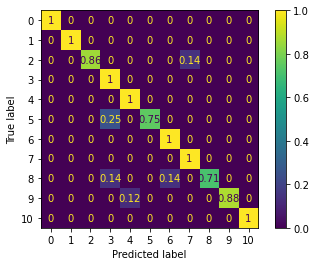

In [61]:
model.evaluate(X_test, y_test)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

prediction = model.predict(X_test)
prediction

prediction_lbl = np.argmax(prediction, axis=1)
test_lbl = y_test

cm = confusion_matrix(test_lbl, prediction_lbl, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Prepare Model for TensorFlowLite on PocketBeagle

In [46]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (Dense)                 (None, 1024)              1180672   
_________________________________________________________________
dropout_18 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_19 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_20 (Dropout)         (None, 1024)              0         
_________________________________________________________________
result (Dense)               (None, 11)               

Convert TF model to TFLite model

In [23]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('test_model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\andre\AppData\Local\Temp\tmppn6r4u0b\assets


Verify TensorFlowLite model works

In [13]:
interpreter = tf.lite.Interpreter(model_path='test_model.tflite')

interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(input_details)

[{'name': 'data_input', 'index': 0, 'shape': array([   1, 1584]), 'shape_signature': array([  -1, 1584]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [128]:
testing_size = X_test[0].size

1584

In [34]:
#Sometimes behaves weird if no resizing of array 
input_data = np.float32(np.resize(X_test[46], (1, testing_size)))
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])
print(np.round(output_data, decimals=3))
print(y_test[46])

[[0.    0.004 0.    0.449 0.007 0.    0.    0.536 0.004 0.   ]]
7


In [26]:
for i in range(0, 113):
    input_data = np.float32(np.resize(X_test[i], (1, testing_size))
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
output_data

Unsure
46


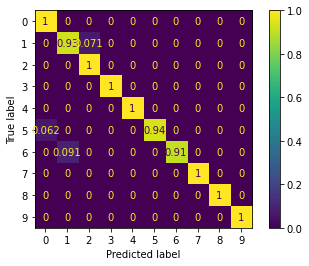

In [102]:
output_lbl = np.argmax(output, axis=1)
test_lbl = y_test

cm = confusion_matrix(test_lbl, output_lbl, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Train model on full data

In [152]:
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow import keras
from tensorflow.keras import layers, callbacks

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model = None
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(1024, activation='relu', name='data')) # relu is used for performance
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(len(gestures), activation='softmax', name='result'))
model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=25, # how many epochs to wait before stopping
    restore_best_weights=True,
    )



testsplit = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2)

for train_index, test_index in testsplit.split(formatwavedata, labels):
    X_train, X_test = formatwavedata[train_index], formatwavedata[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

history = model.fit(X_train, y_train, 
                    epochs=600,
                    batch_size=32,
                    callbacks=[early_stopping],
                    validation_data=(X_val, y_val),
                    verbose=1)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('number_model.tflite', 'wb') as f:
  f.write(tflite_model)


Epoch 1/600
14/14 [==============================] - 1s 53ms/step - loss: 2.4136 - sparse_categorical_accuracy: 0.1182 - val_loss: 2.3188 - val_sparse_categorical_accuracy: 0.0964
Epoch 2/600
14/14 [==============================] - 1s 44ms/step - loss: 2.3183 - sparse_categorical_accuracy: 0.1795 - val_loss: 2.2308 - val_sparse_categorical_accuracy: 0.3855
Epoch 3/600
14/14 [==============================] - 1s 43ms/step - loss: 2.2644 - sparse_categorical_accuracy: 0.2364 - val_loss: 2.1301 - val_sparse_categorical_accuracy: 0.5422
Epoch 4/600
14/14 [==============================] - 1s 44ms/step - loss: 2.1839 - sparse_categorical_accuracy: 0.2750 - val_loss: 2.0414 - val_sparse_categorical_accuracy: 0.4699
Epoch 5/600
14/14 [==============================] - 1s 45ms/step - loss: 2.0822 - sparse_categorical_accuracy: 0.3386 - val_loss: 1.9238 - val_sparse_categorical_accuracy: 0.4337
Epoch 6/600
14/14 [==============================] - 1s 42ms/step - loss: 1.9834 - sparse_categorica

14/14 [==============================] - 1s 42ms/step - loss: 0.0986 - sparse_categorical_accuracy: 0.9682 - val_loss: 0.1165 - val_sparse_categorical_accuracy: 0.9639
Epoch 92/600
14/14 [==============================] - 1s 47ms/step - loss: 0.0982 - sparse_categorical_accuracy: 0.9682 - val_loss: 0.1115 - val_sparse_categorical_accuracy: 0.9759
Epoch 93/600
14/14 [==============================] - 1s 53ms/step - loss: 0.0825 - sparse_categorical_accuracy: 0.9727 - val_loss: 0.1281 - val_sparse_categorical_accuracy: 0.9518
Epoch 94/600
14/14 [==============================] - 1s 54ms/step - loss: 0.0885 - sparse_categorical_accuracy: 0.9795 - val_loss: 0.1107 - val_sparse_categorical_accuracy: 0.9639
Epoch 95/600
14/14 [==============================] - 1s 54ms/step - loss: 0.0502 - sparse_categorical_accuracy: 0.9886 - val_loss: 0.1128 - val_sparse_categorical_accuracy: 0.9759
Epoch 96/600
14/14 [==============================] - 1s 44ms/step - loss: 0.0778 - sparse_categorical_accur

INFO:tensorflow:Assets written to: C:\Users\andre\AppData\Local\Temp\tmp2e0mnc20\assets


3/3 [==============================] - 0s 18ms/step - loss: 0.0759 - sparse_categorical_accuracy: 0.9759


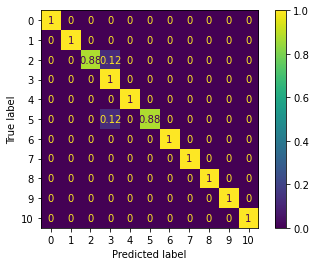

In [153]:
model.evaluate(X_val, y_val)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

prediction = model.predict(X_val)
prediction

prediction_lbl = np.argmax(prediction, axis=1)
test_lbl = y_val

cm = confusion_matrix(test_lbl, prediction_lbl, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()